In [26]:
import pandas as pd
import seaborn as sb
import numpy as np
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [27]:
df=pd.read_csv('winequality-red.csv')


In [28]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# Pre processing data:

## Checking and removing null values(if any):

In [3]:
df.isnull().sum()
#no null values

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

## Boxplot to check Outliers 

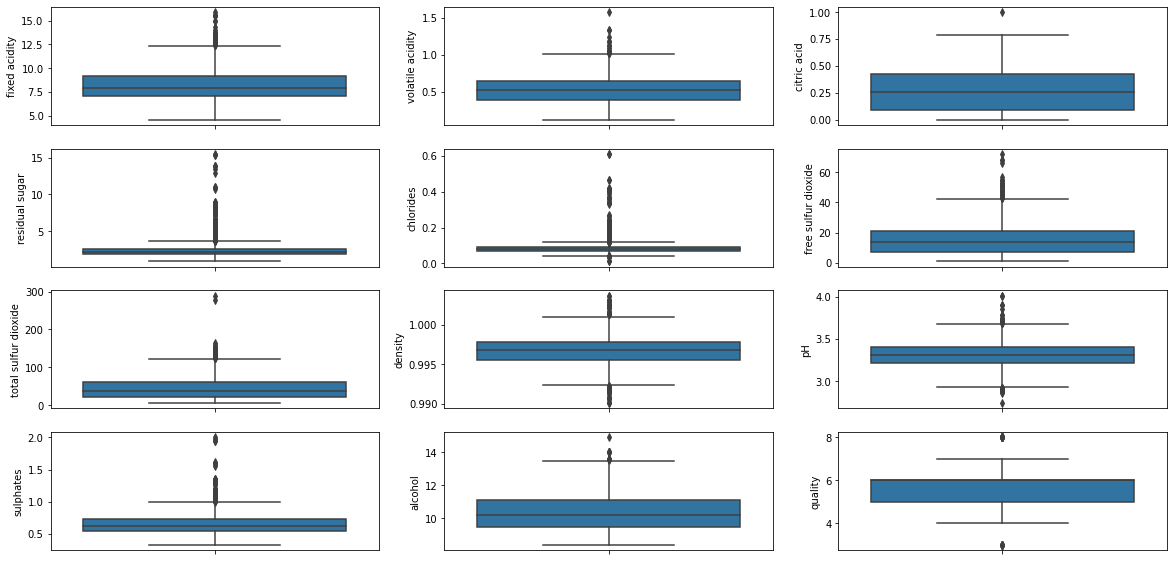

In [4]:
figure,ax=plt.subplots(4,3,figsize=(20,10))
index=0
ax=ax.flatten()

for col,values in df.items():
    sb.boxplot(y=col,data=df,ax=ax[index])
    index+=1

## Distribution plots  

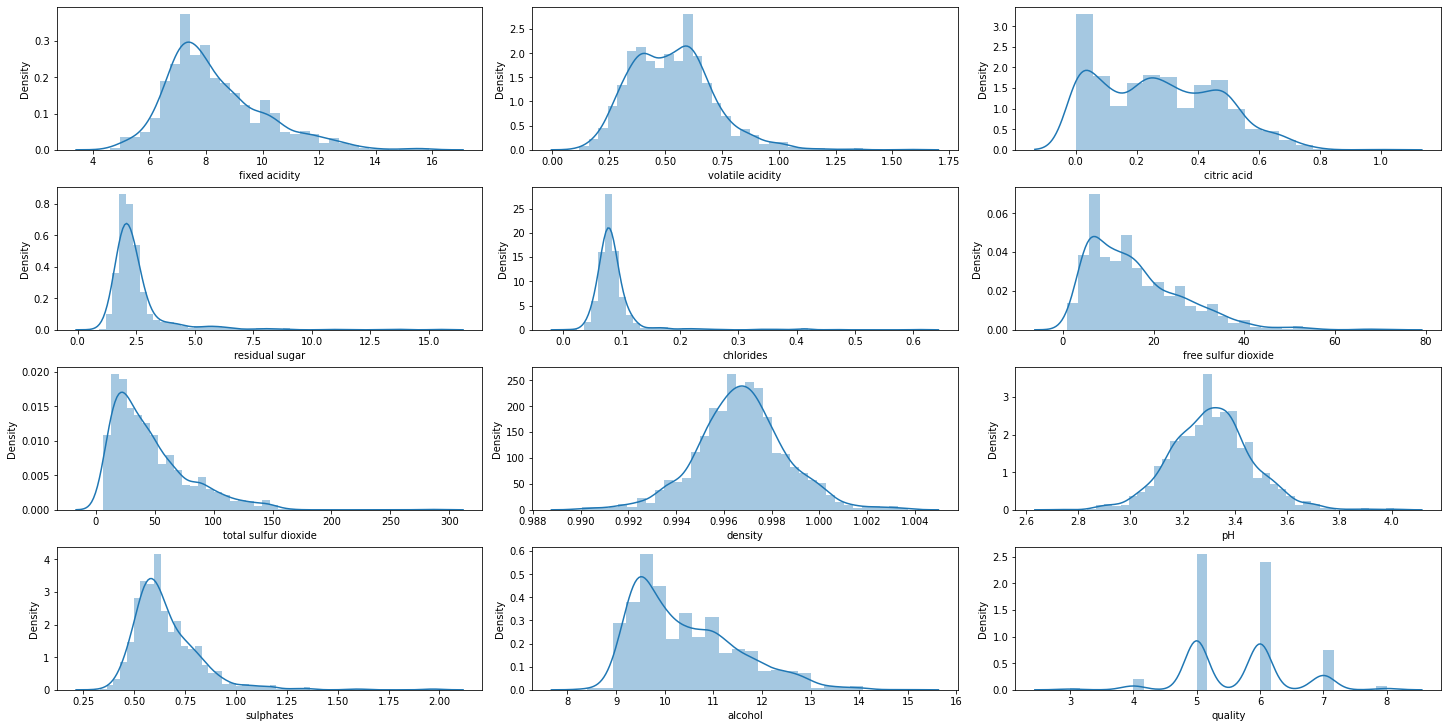

In [5]:
figure,ax=plt.subplots(4,3,figsize=(20,10) , constrained_layout=True )
index=0
ax=ax.flatten()

for col,values in df.items():
    sb.distplot(values,ax=ax[index])
    index+=1

Removing/Balancing Outliers 

In [6]:
for col,values in df.items():
    mean=np.mean(values)
    std=np.std(values)
    limit=std*1.5
    lb=mean-limit
    ub=mean+limit
    for i in range(len(values)):
        if values[i]<lb:
            values[i]=lb
        elif values[i]>ub:
            values[i]=ub
    index+=1

Checking Boxplot again to observe outliers 

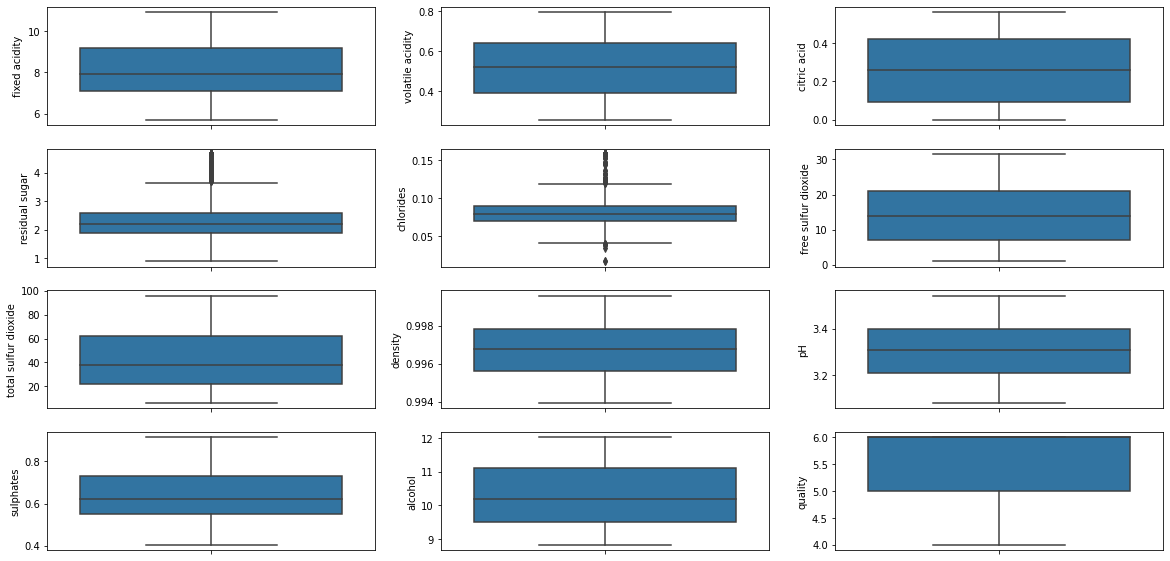

In [7]:
figure,ax=plt.subplots(4,3,figsize=(20,10))
index=0
ax=ax.flatten()

for col,values in df.items():
    sb.boxplot(y=col,data=df,ax=ax[index])
    index+=1                                   

## Correlation matrix
checking correlation between features 

<AxesSubplot:>

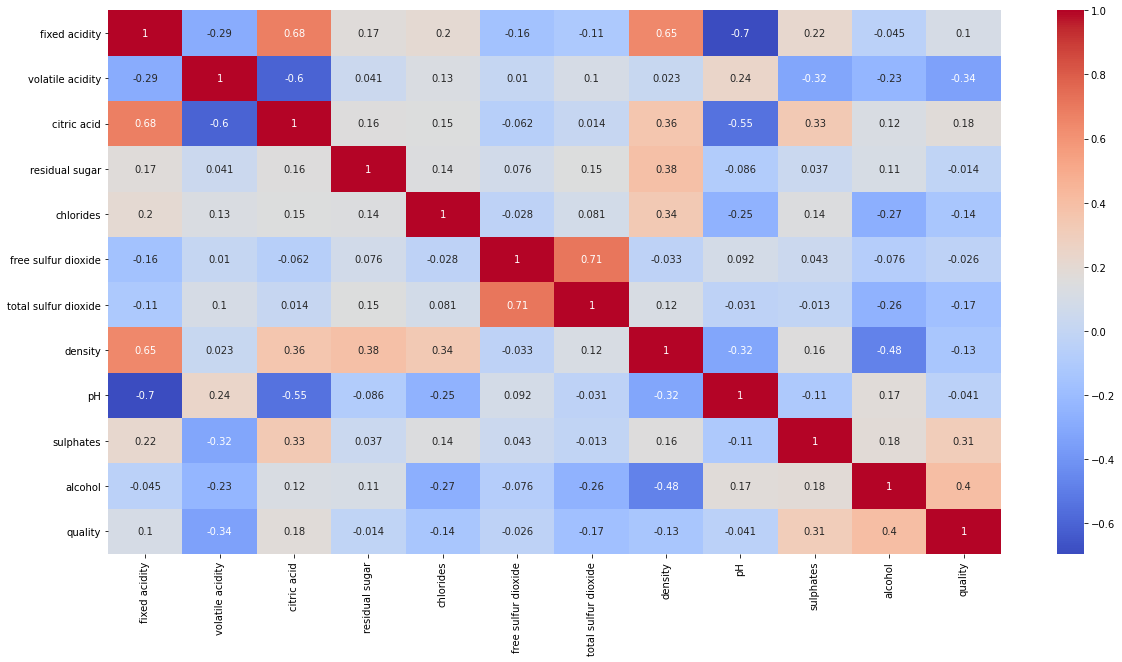

In [8]:
corr = df.corr()
plt.figure(figsize=(20,10))
sb.heatmap(corr, annot=True,cmap='coolwarm')

Splitting our data into an X array that contains the features to train on, and a y array with the target feature

In [9]:

X = df.drop(columns=['quality'])

y = df['quality']                          # target feature 

# we can drop 'free sulfur dioxide' column as it is highly correlated with 'total sulfur dioxide' and only one feature will 
# be sufficient out of this two  

Checking how the data is distributed into different Quality class 

6    855
5    681
4     63
Name: quality, dtype: int64


<AxesSubplot:xlabel='quality', ylabel='count'>

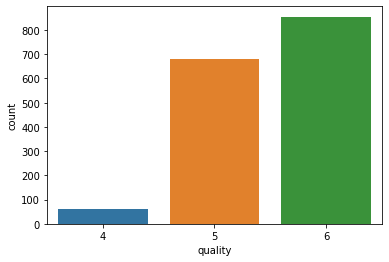

In [10]:
print(y.value_counts())    

sb.countplot(x='quality',data=df)     

As seen from above plot that more samples belongs to Quality classes 5,6 and less to 4. Hence the model will become bias towards class 5 and 6 and tend to ignore Minority class i.e, 4 while prediction.  
Hence Class Imbalancement is required 

## Class Imbalancement 
Class Imbalancement is done by generating synthetic samples (from nearest neighbour values) for minority class using SMOTE technique 

In [11]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()

X,y = oversample.fit_resample(X,y)


In [20]:
print(y.value_counts())    
  

4    855
6    855
5    855
Name: quality, dtype: int64


In [308]:
Data = df.drop(['quality'], axis=1)
labels = df['quality']

In [309]:
labels = np.array(labels)
labels = labels-3*np.ones((1599,))

In [310]:
set(labels)

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}

In [311]:
Data = np.array(Data)

In [312]:
from sklearn.model_selection import train_test_split

In [313]:
X_train, X_test, y_train, y_test = train_test_split(Data, labels, test_size=0.20, random_state=126)

In [314]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.fit_transform(X_test)

In [315]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import History 
from tensorflow.keras.optimizers import Adam

In [316]:
y_train_nn=to_categorical(y_train,6,'int')
y_test_nn=to_categorical(y_test,6,'int')

In [317]:
X_t, X_v, y_t, y_v = train_test_split(X_train, y_train_nn, test_size=0.20, random_state=126)

In [318]:
X_t.shape[1]

11

In [319]:
input_shape=X_t.shape[1]

In [320]:
inp=Input(shape=(input_shape,))
model = Dense(11,activation='relu')(inp)
model = Dense(11,activation='relu')(model)
model = Dense(6,activation='softmax')(model)

model = Model(inputs=inp,outputs=model)
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
es=EarlyStopping(monitor='val_loss',patience=3,verbose=1)

In [321]:
model.fit(X_t, y_t, validation_data=(X_v, y_v), verbose=1, epochs = 250, batch_size=24, shuffle=True, callbacks=[es])

Epoch 1/250
43/43 [==============================] - 0s 4ms/step - loss: 1.8105 - accuracy: 0.0880 - val_loss: 1.7050 - val_accuracy: 0.2070
Epoch 2/250
43/43 [==============================] - 0s 1ms/step - loss: 1.6172 - accuracy: 0.3568 - val_loss: 1.5339 - val_accuracy: 0.3906
Epoch 3/250
43/43 [==============================] - 0s 2ms/step - loss: 1.4508 - accuracy: 0.4585 - val_loss: 1.3549 - val_accuracy: 0.4453
Epoch 4/250
43/43 [==============================] - 0s 2ms/step - loss: 1.2915 - accuracy: 0.4829 - val_loss: 1.2060 - val_accuracy: 0.4453
Epoch 5/250
43/43 [==============================] - 0s 2ms/step - loss: 1.1924 - accuracy: 0.5103 - val_loss: 1.1264 - val_accuracy: 0.4648
Epoch 6/250
43/43 [==============================] - 0s 1ms/step - loss: 1.1403 - accuracy: 0.5288 - val_loss: 1.0790 - val_accuracy: 0.4922
Epoch 7/250
43/43 [==============================] - 0s 1ms/step - loss: 1.1034 - accuracy: 0.5591 - val_loss: 1.0434 - val_accuracy: 0.5234
Epoch 8/250
4

In [322]:
model.predict(X_test)

array([[3.5547058e-03, 2.5717072e-02, 5.4810739e-01, 4.0779144e-01,
        1.4379468e-02, 4.4999117e-04],
       [7.1452549e-03, 3.9179325e-02, 2.8708968e-01, 4.9626291e-01,
        1.4969373e-01, 2.0629143e-02],
       [3.9806655e-03, 9.6187107e-03, 4.7495404e-01, 4.8110601e-01,
        2.9129012e-02, 1.2116447e-03],
       ...,
       [1.3103184e-02, 6.7142323e-02, 3.0155602e-01, 5.5424047e-01,
        5.7246771e-02, 6.7112269e-03],
       [1.3894828e-04, 2.0399052e-03, 6.8385017e-01, 2.9784843e-01,
        1.5143313e-02, 9.7930711e-04],
       [9.6629336e-03, 2.8253837e-02, 5.7866824e-01, 3.5230774e-01,
        3.0010320e-02, 1.0968915e-03]], dtype=float32)

In [323]:
def some_function(x):
    y = np.zeros(x.shape[0]).astype(int)
    print(x.shape[0])
    for i in range(x.shape[0]):
        max=0
        count = -1
        for j in range(x.shape[1]):
            if x[i][j] > max:
                max = x[i][j]
                count = j;
        y[i]=int(count)
    return y

In [324]:
y_pred = some_function(model.predict(X_test))

320


In [325]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_pred,y_test))

0.60625
